In [ ]:
!pip install accelerate -U
!pip install transformers[torch]


In [ ]:
!pip show accelerate


In [3]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# 加载数据
data_path = './data/'
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

train_df = train_df[['review', 'star']]
train_df = train_df.sample(n=2000, random_state=41)  # 确保有足够的数据进行训练和评估
test_df = test_df[['review', 'star']]
test_df = test_df.sample(n=400, random_state=21)

# 初始化分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 数据预处理函数
def preprocess_data(df):
    def tokenize_function(examples):
        return tokenizer(examples['review'], truncation=True, padding=True)

    dataset = Dataset.from_pandas(df)
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    return tokenized_dataset

# 预处理训练集和测试集
train_dataset = preprocess_data(train_df)
test_dataset = preprocess_data(test_df)

# 添加标签
def add_labels(example):
    example['labels'] = float(example['star'])  # 确保标签是浮点类型用于回归任务
    return example

train_dataset = train_dataset.map(add_labels)
test_dataset = test_dataset.map(add_labels)

# 加载预训练的BERT模型
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=1)  # num_labels=1 表示回归任务

# 定义训练参数
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',  # 用于存储日志
    logging_steps=10,
)

# 创建Trainer实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 开始训练
trainer.train()

# 评估模型
results = trainer.evaluate()
print(results)

# 保存模型
trainer.save_model('./results/final_model')


'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-chinese/resolve/main/vocab.txt (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000002B60545E3D0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/bert-base-chinese/resolve/main/vocab.txt


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Administrator.JINBAOSLAPTOP\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.531000,0.572484
2,0.534400,0.567005
3,0.429100,0.476339


{'eval_loss': 0.476338654756546, 'eval_runtime': 328.1198, 'eval_samples_per_second': 1.219, 'eval_steps_per_second': 0.122, 'epoch': 3.0}


In [ ]:
!pip install tensorflow tensorboard


All tags for ./logs/events.out.tfevents.1719345301.JinbaosLaptop.6116.0: ['train/loss', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
Train losses (File 1): [6.51800012588501, 1.2283999919891357, 1.1224000453948975, 1.0979000329971313, 0.8183000087738037, 0.9265000224113464, 0.8901000022888184, 1.0827000141143799, 0.9692000150680542, 0.6226999759674072]
Eval losses (File 1): [0.5724840760231018, 0.5670046210289001, 0.476338654756546]


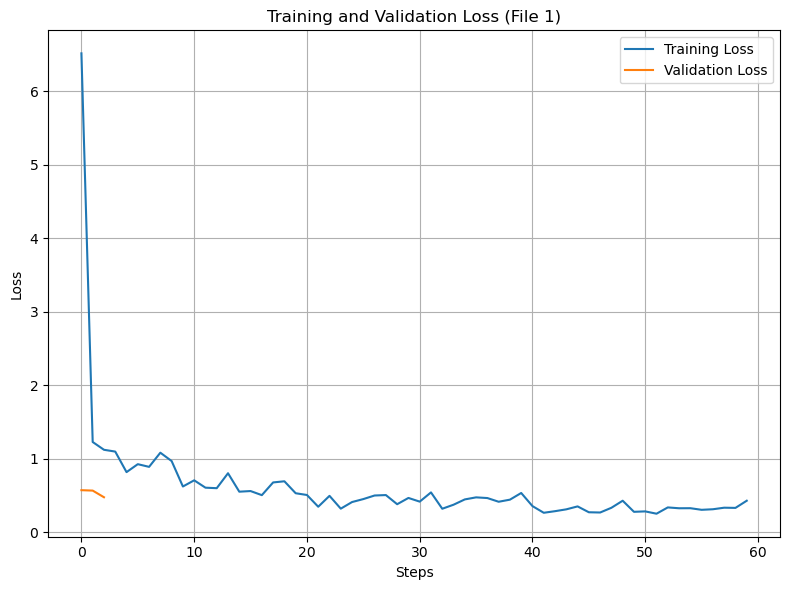

In [9]:
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

def load_and_extract_losses(log_file):
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    tags = event_acc.Tags()['scalars']
    print(f"All tags for {log_file}: {tags}")

    train_losses = []
    eval_losses = []

    if 'train/loss' in tags:
        train_events = event_acc.Scalars('train/loss')
        train_losses = [event.value for event in train_events]
    else:
        print(f"No 'train/loss' tag found in {log_file}.")

    if 'eval/loss' in tags:
        eval_events = event_acc.Scalars('eval/loss')
        eval_losses = [event.value for event in eval_events]
    else:
        print(f"No 'eval/loss' tag found in {log_file}.")

    return train_losses, eval_losses

# 加载并提取第一个事件文件的损失数据
log_file1 = './logs/events.out.tfevents.1719345301.JinbaosLaptop.6116.0'
train_losses1, eval_losses1 = load_and_extract_losses(log_file1)

# 检查数据是否正确提取
print(f"Train losses (File 1): {train_losses1[:10]}")
print(f"Eval losses (File 1): {eval_losses1[:10]}")

# 绘制损失曲线
plt.figure(figsize=(8, 6))

if train_losses1:
    plt.plot(train_losses1, label='Training Loss')
plt.plot(eval_losses1, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (File 1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# 测试
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model_name = './results/final_model'
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForSequenceClassification.from_pretrained(model_name)

texts = ["就菜的口味来说，还是可以的，有的菜略咸，例如全家福，但是总体就家常菜来说还不错，淮扬菜鲜咸的味道基本都有；就团购的质量来说，欠诚意，小炒鳝丝变辣椒炒肉丝，其中成本降低多少我们就不说了，你至少应该在团购网页上说清楚，遇到较真的顾客不会像我们这么好说话的，不是自己给自己找麻烦么；红烧牛肉丸中的牛肉丸吃在嘴里就像超市里卖的撒尿牛丸，真的有牛肉吗？我怀疑。其实口味还不错的一家店，如果诚意满满，好好做生意，我觉得应该有不少回头客，但是这样偷梁换柱做团购，是指望能捞一笔是一笔么？没有这个量还做什么团购？"]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

model.eval()

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

predictions = logits.squeeze().tolist()
print(predictions)


2.2217910289764404
